In [1]:
import os
import sys

import torch
from torch import nn, autograd, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

sys.path.append(os.path.dirname(os.getcwd()))
from pyfed.metrics import hessian as hs
from pyfed.models.cnns import SimpleCNN

In [2]:
device = torch.device('cuda:0')
trainset = CIFAR10('~/data', train=True, transform=ToTensor())
trainloader = DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
inputs, targets = map(lambda x: x.to(device), next(iter(trainloader)))
criterion = nn.CrossEntropyLoss()

In [3]:
torch.manual_seed(42)
# net_teacher = resnet18(num_classes=10).to(device).eval()
net_teacher = SimpleCNN().to(device).eval()
torch.manual_seed(43)
# net_student = resnet18(num_classes=10).to(device).eval()
net_student = SimpleCNN().to(device).eval()

In [4]:
optimizer = optim.Adam(net_student.parameters())

In [5]:
v = [torch.randn(p.size()).to(device) for p in net_student.parameters()]
hess_t = hs.Hessian(net_teacher, criterion, trainset, batch_size=32)
hess_s = hs.Hessian(net_student, criterion, trainset, batch_size=32)

In [6]:
data, target = next(iter(trainloader))

In [7]:
eigval_t, eigvec_t = hess_t.eigenvalues(top_n=3, seed=1)
eigval_s, eigvec_s = hess_s.eigenvalues(top_n=3, seed=1, create_graph=True)

In [11]:
dists = [sum([torch.sum((ev_t_param-ev_s_param)**2) for ev_t_param, ev_s_param in zip(ev_t_i, ev_s_i)])**0.5 for ev_t_i, ev_s_i in zip(eigvec_t, eigvec_s)]

In [18]:
loss = criterion(net_student(data.cuda()), target.cuda())

In [7]:
Hv = torch.autograd.grad(hess.gradsH, hess.params, grad_outputs=v, retain_graph=True, create_graph=True)

In [24]:
from tqdm import tqdm

In [8]:
from torchviz import make_dot

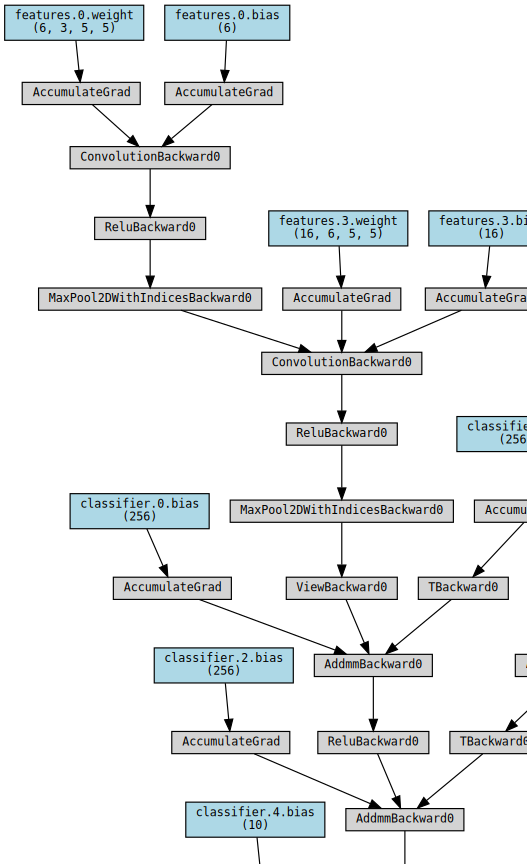

In [19]:
graph = make_dot(loss, params=dict(net_student.named_parameters()))
graph

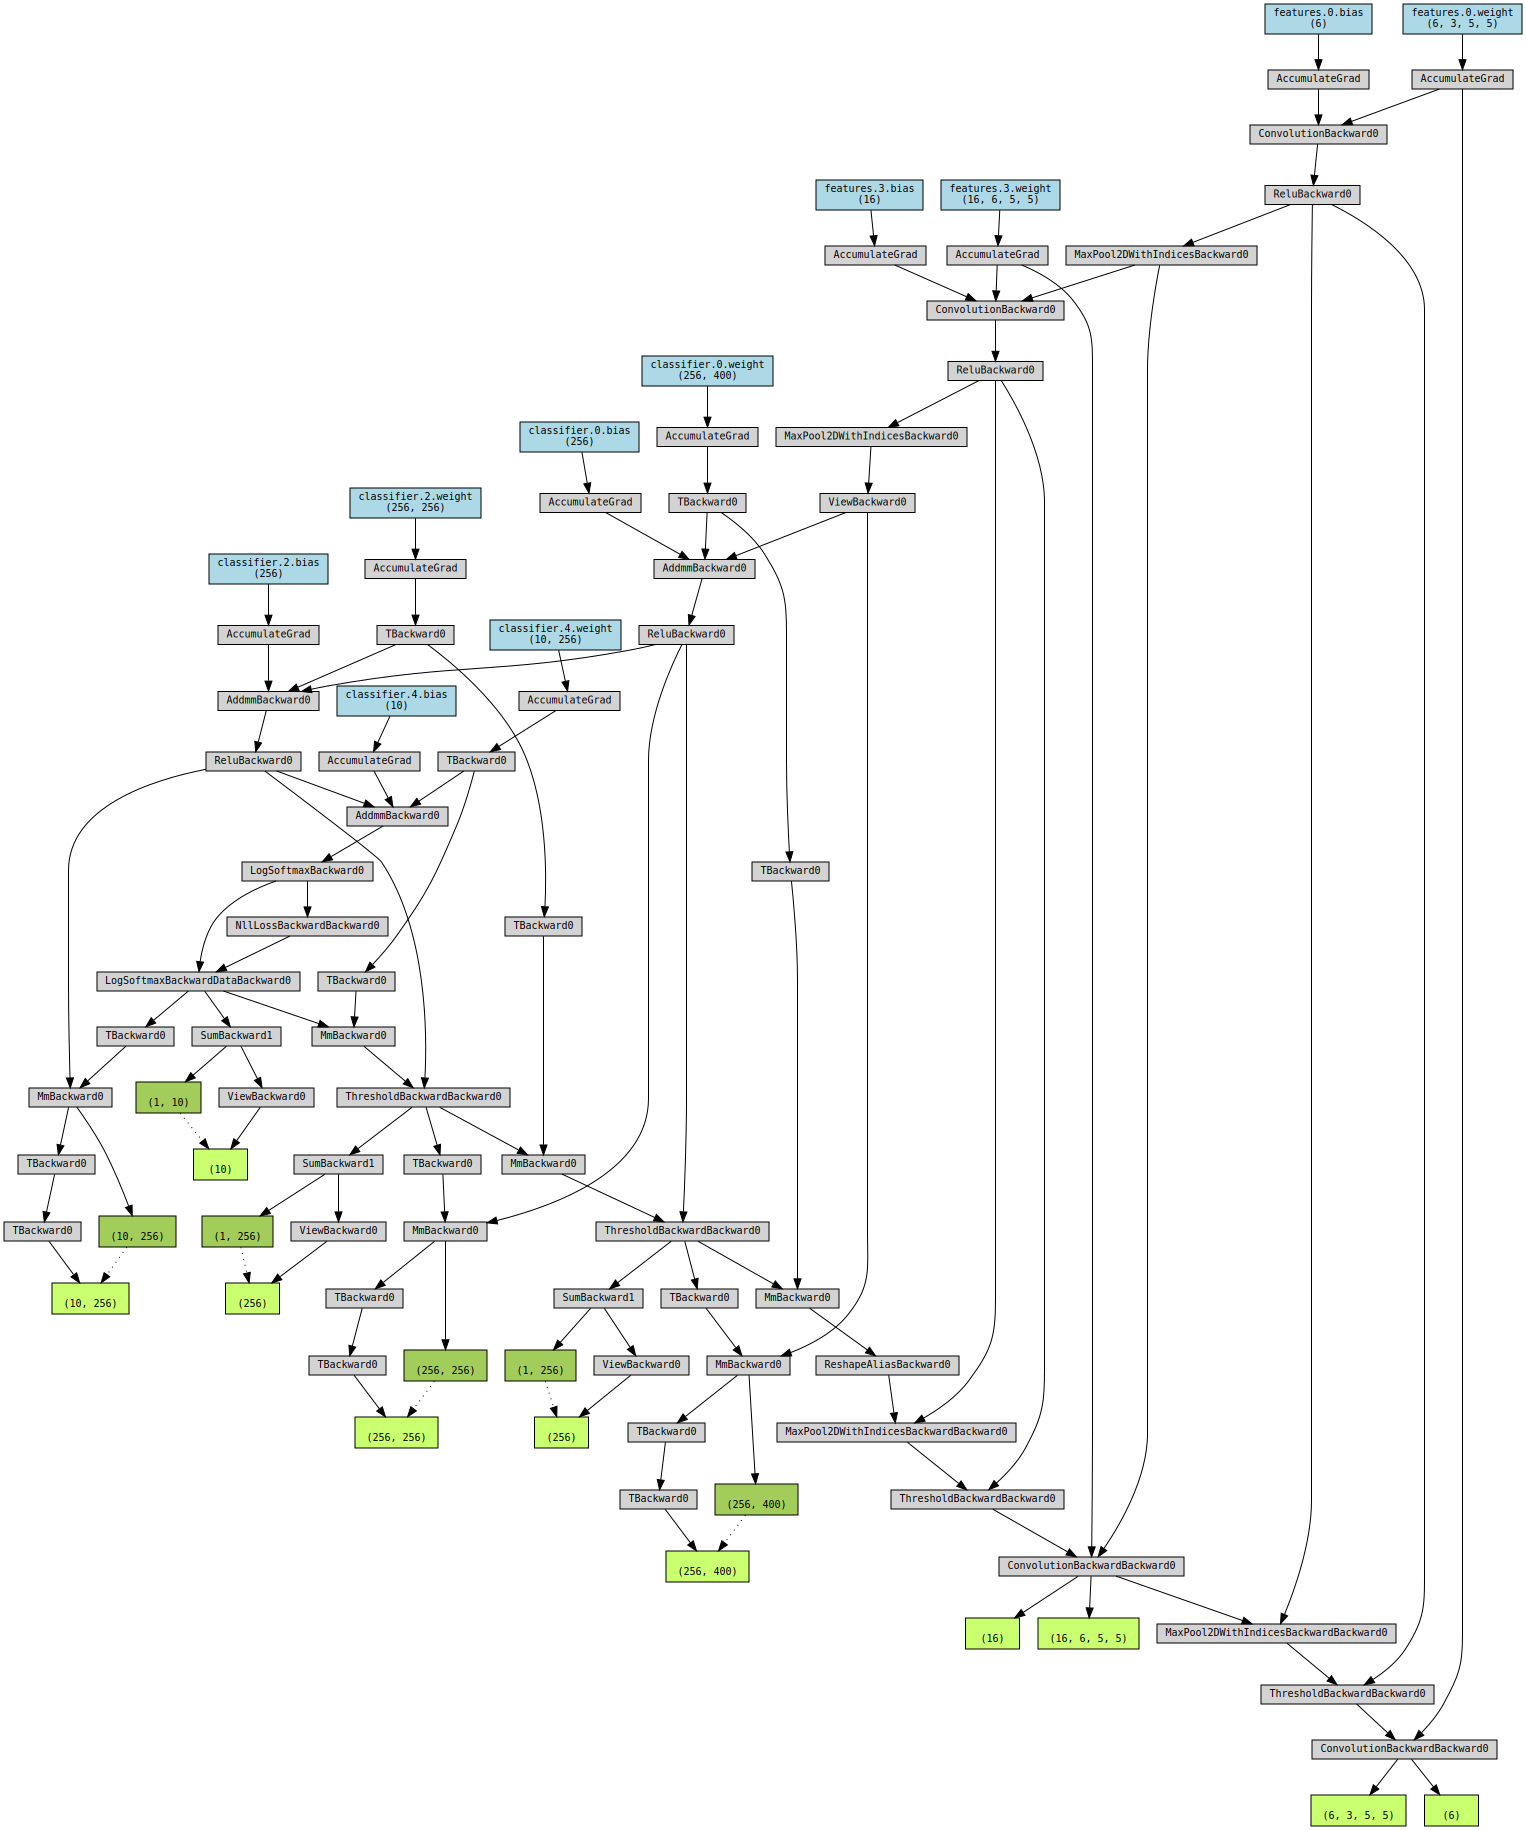

In [20]:
graph = make_dot(hess.gradsH, params=dict(net_student.named_parameters()))
graph

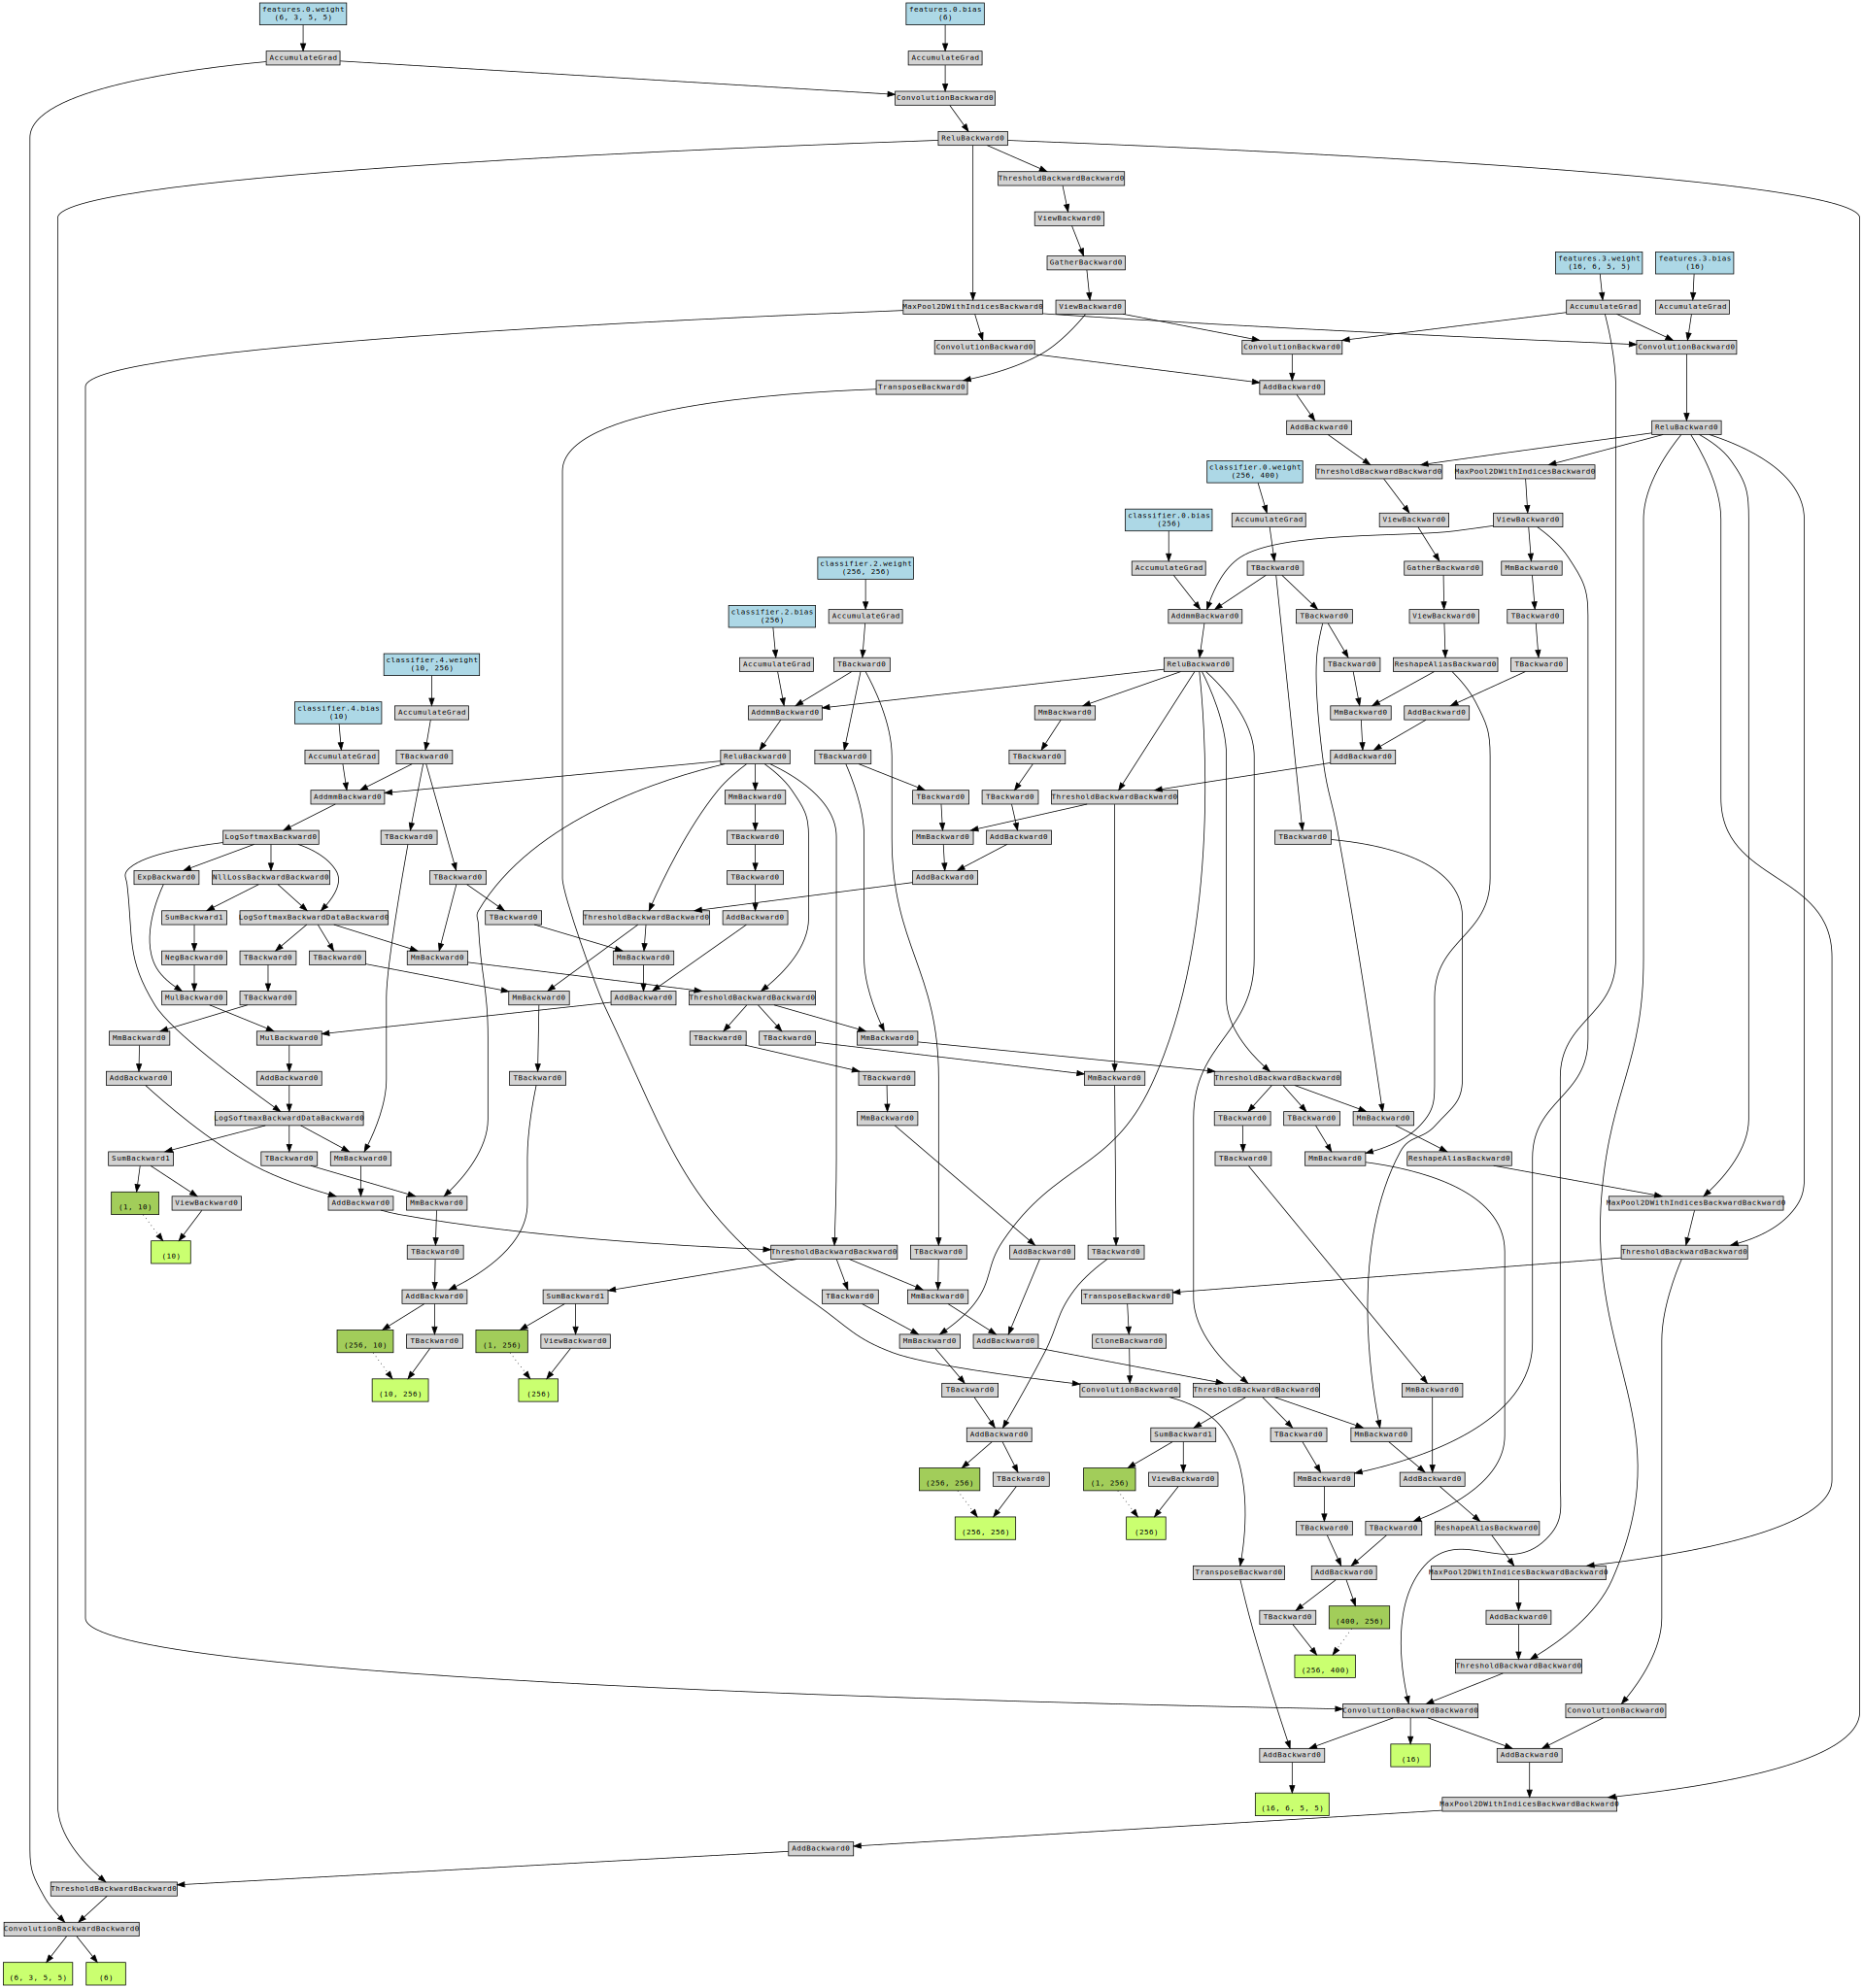

In [9]:
make_dot(Hv, params=dict(net_student.named_parameters()))

In [17]:
v[-1].grad

In [5]:
eigval, eigvec = hess.eigenvalues(top_n=3, seed=1, )

In [6]:
eigvec[0][0].requires_grad

False

In [ ]:
import torch

# Define the eigenvector distance loss function
def eigenvector_distance_loss(eigenvectors):
    """
    Calculate the squared difference between the first and second eigenvectors
    """
    return torch.sum((eigenvectors[0] - eigenvectors[1])**2)

# Define the current model parameters and eigenvectors
model = ...
eigenvectors = ...

# Compute the loss function
loss = eigenvector_distance_loss(eigenvectors)

# Compute the gradient of the loss with respect to the model parameters
grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

# Evaluate the gradient at a point near the current value of the model parameters
params_new = [param + 0.01 * grad for param, grad in zip(model.parameters(), grads)]
loss_new = eigenvector_distance_loss(eigenvectors)

# Compute the first-order approximation of the loss using Taylor expansion
loss_approx = loss + 0.01 * torch.sum(grads[i] * (params_new[i] - param) for i, param in enumerate(model.parameters()))